In [1]:
from significance_of_mean_cuda import significance_of_mean_cuda
from utils import significance_of_mean, getdf, my_scatter_plot
import numpy as np
import time
import multiprocessing
import concurrent.futures as cf
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import seaborn as sns

In [3]:
import matplotlib as mpl

mpl.rcParams['text.usetex'] = False  # not really needed

### Get synthetic data

In [4]:
num_examples = 1

In [5]:
N = [50,100, 150, 200, 250]
s =  [10, 50, 100, 200]

#### The calculations are parallelized over the samples on five cores in total. 

In [6]:
def p_value_calc(args):
    a,b, bins = args
    p=significance_of_mean(a,b, bins)[0]
    return p

def calibration_series_generator(A,B, S):
    num_tests = A.shape[0]
    for i in range(num_tests):
        a_sample = A[i].tolist()
        b_sample = B[i].tolist()
        yield ([a_sample,b_sample, S])

def calibration_test(A,B,bins):
    with cf.ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()-3) as pool:
        p_list = list(pool.map(p_value_calc, calibration_series_generator(A,B, bins)))
    return p_list
    

In [7]:
cpu = list()
gpu = list()
n = N[1]
for bins in s:
    np.random.seed(42)
    A = np.asarray([np.random.normal(0, 1, n) for _ in range(num_examples)])
    B = np.asarray([np.random.normal(0, 1, n) for _ in range(num_examples)])

    start = time.time()
    SGM = significance_of_mean_cuda(bins,dtype_v=np.uint16,dtype_A=np.float64)
    SGM.run(A,B)
    p = SGM.get_p_values()
    end = time.time()
    t_gpu = end - start
    gpu.append(t_gpu)
    print("GPU: ", t_gpu)
    
    
    start = time.time()
    P = calibration_test(A,B,bins)
    end = time.time()
    t_cpu = end - start
    cpu.append(t_cpu)
    print("CPU1: ",t_cpu)
    
    print(np.allclose(p,P))
    

GPU:  0.018578052520751953
CPU1:  0.19416213035583496
True
GPU:  0.0218198299407959
CPU1:  1.8020751476287842
True
GPU:  0.02892923355102539
CPU1:  3.918332099914551
True
GPU:  0.09453868865966797
CPU1:  7.960726022720337
True


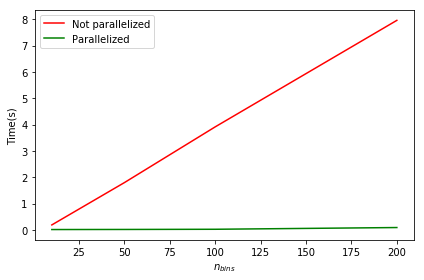

In [8]:
plt.plot(s, cpu, 'r-', label='Not parallelized')
plt.plot(s, gpu, 'g-', label='Parallelized')
plt.legend(loc='upper left')
plt.xlabel(r"$n_{bins}$")
plt.ylabel("Time(s)")
plt.tight_layout()
plt.savefig("figures/normal_S")
plt.show()

In [9]:
cpu = list()
gpu = list()
bins = s[2]
for n in N:
    np.random.seed(42)
    A = np.asarray([np.random.normal(0, 1, n) for _ in range(num_examples)])
    B = np.asarray([np.random.normal(0, 1, n) for _ in range(num_examples)])

    start = time.time()
    SGM = significance_of_mean_cuda(bins,dtype_v=np.uint16,dtype_A=np.float64)
    SGM.run(A,B)
    p = SGM.get_p_values()
    end = time.time()
    t_gpu = end - start
    gpu.append(t_gpu)
    print("GPU: ", t_gpu)
    
    
    start = time.time()
    P = calibration_test(A,B,bins)
    end = time.time()
    t_cpu = end - start
    cpu.append(t_cpu)
    print("CPU: ",t_cpu)
    
    print(np.allclose(p,P))

GPU:  0.01291966438293457
CPU:  0.4345221519470215
True
GPU:  0.029415369033813477
CPU:  3.8483190536499023
True
GPU:  0.14047765731811523
CPU:  12.279670715332031
True
GPU:  0.28668951988220215
CPU:  32.0190167427063
True
GPU:  0.8356788158416748
CPU:  65.00329852104187
True


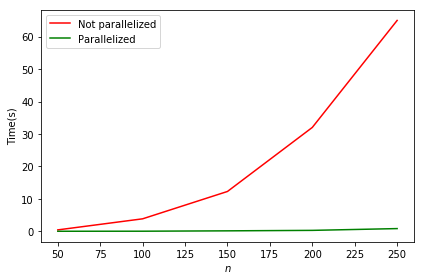

In [10]:
plt.plot(N, cpu, 'r-', label='Not parallelized')
plt.plot(N, gpu, 'g-', label='Parallelized')
plt.legend(loc='upper left')
plt.xlabel(r"$n$")
plt.ylabel("Time(s)")
plt.tight_layout()
plt.savefig("figures/normal_N")
plt.show()

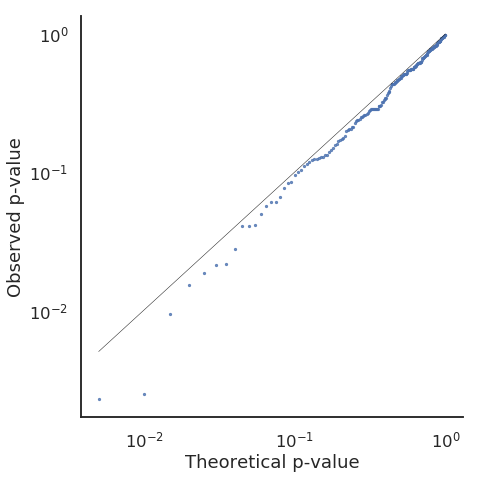

In [11]:
num_examples = 200
n = N[1]
bins = s[2]

np.random.seed(42)
A = np.asarray([np.random.normal(0, 1, n) for _ in range(num_examples)])
B = np.asarray([np.random.normal(0, 1, n) for _ in range(num_examples)])

SGM = significance_of_mean_cuda(bins,dtype_v=np.uint16,dtype_A=np.float64)
SGM.run(A,B)
p = SGM.get_p_values()

pDf = getdf(p, num_examples)
my_scatter_plot(pDf,"figures/normal_calibration")